# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

## Load Data

In [2]:
# dataset based on R produced dataset
nba = pd.read_csv('nba_feature_engineer.csv')

In [3]:
# dataset dimensions
nba.shape

(21882, 81)

In [4]:
# dataset dimensions after dropping rows with missing data
nba.dropna().shape

(19288, 81)

## Drop rows with missing data

In [5]:
nba_clean = nba.dropna().copy()

## Make point spread +/- based on favored column

In [6]:
nba_clean.loc[:,'spread'] = (nba_clean
                             .apply(lambda row: row['spread'] if row['favored'] == 'H' else row['spread'] * -1,
                                    axis=1))

## Encode team names as numeric val

In [7]:
lb_encode = LabelEncoder()
nba_clean.loc[:,'away_code'] = lb_encode.fit_transform(nba_clean['away'])
nba_clean.loc[:,'home_code'] = lb_encode.fit_transform(nba_clean['home'])

## Split off 2017 season as testing set and everything earlier as training

In [8]:
train_nba = nba_clean.query('seas <= 2016')
test_nba = nba_clean.query('seas > 2016')

## Setup up model

In [9]:
# import RF
rf = RandomForestRegressor(n_jobs=-1, 
                           oob_score=True)

# setup hyperparameters for RandomSearch
n_estimators = [50, 75, 100, 150]
criterion = ['mse','mae']
min_samples_leaf = [1,3,5,7,11,23]
max_features = ['sqrt','log2',0.5]

hyperparameters = dict(n_estimators=n_estimators,
                       criterion=criterion,
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features)
# Set up RandomSearchCV
rand_srch_cv = RandomizedSearchCV(rf, hyperparameters, random_state=702, n_iter=10, cv=3, verbose=0, n_jobs=-1)

## Split training set into training and validation set

In [11]:
training_df = train_nba.query('seas <= 2015')
val_df = train_nba.query('seas == 2016')

## Drop columns and setup X_train and y_train

In [12]:
cols_to_drop = ['spread','favored',
                'total','homescore',
                'awayscore','mov',
                'gid','min_played',
                'home_win','home',
                'away']
y_train = training_df.mov.values
X_train = training_df.drop(cols_to_drop, axis=1)

## Running RandomizedSearchCV to find best model

In [ ]:
best_model = rand_srch_cv.fit(X_train, y_train)

In [16]:
# Best scores
best_model.best_score_

0.16735146223980896

## Get predictions for validation set

In [17]:
model_preds = best_model.predict(val_df.drop(cols_to_drop,axis=1))

## RMSE for predictions vs point spread

In [18]:
np.sqrt(mean_squared_error(model_preds, val_df.mov))

13.02788867171533

In [19]:
np.sqrt(mean_squared_error(val_df.spread, val_df.mov))

12.487332678580817

## How often does prediction beat closing line

In [20]:
def bcl(pred, result):
    return abs(pred - result)

In [22]:
model_resid = bcl(model_preds, val_df.mov)
spread_resid = bcl(val_df.spread, val_df.mov)

np.mean(model_resid < spread_resid)

0.4610951008645533

## Get test set predictions

In [24]:
test_preds = best_model.predict(test_nba.drop(cols_to_drop,axis=1))

## Test set RMSE predictions vs spread

In [25]:
np.sqrt(mean_squared_error(test_preds, test_nba.mov))

12.606579086187145

In [27]:
np.sqrt(mean_squared_error(test_nba.spread, test_nba.mov))

12.163663257125815

In [ ]:
model_resid = bcl(tes_preds, val_df.mov)
spread_resid = bcl(val_df.spread, val_df.mov)

np.mean(model_resid < spread_resid)

## Plot spreads vs model

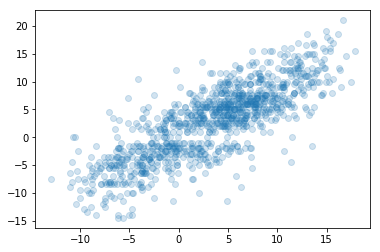

In [45]:
plt.scatter(model_preds, val_df.spread,alpha=.2)

## Plot distributions of predictions, spreads, and mov's

(array([  4.,  20.,  51., 189., 224., 292., 172.,  64.,  18.,   7.]),
 array([-44. , -34.7, -25.4, -16.1,  -6.8,   2.5,  11.8,  21.1,  30.4,
         39.7,  49. ]),
 <a list of 10 Patch objects>)

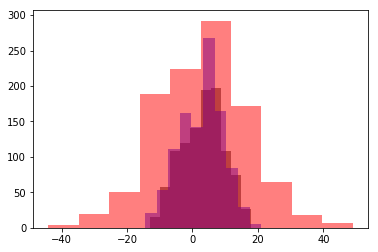

In [34]:
plt.hist(model_preds.round(),bins=10,alpha=.5,color='black')
plt.hist(val_df.spread,alpha=.5,color='blue')
plt.hist(val_df.mov,alpha=.5,color='red')

## Plot grouping of predictions vs avg mov

In [36]:
val_df.loc[:,'preds'] = model_preds.round(1)

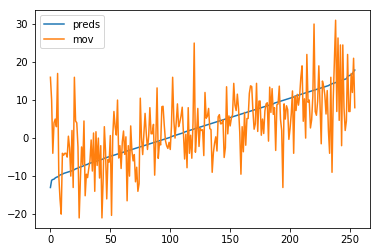

In [37]:
val_df.groupby('preds',as_index=False)[['mov']].mean().plot()

## Create results dataframe

In [38]:
results_df = pd.DataFrame()
results_df['mov'] = test_nba.mov
results_df['ps'] = test_nba.spread
results_df['model'] = test_preds

In [ ]:
results_df.head()